In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.graph_objects as go
from tabulate import tabulate
from plotly.subplots import make_subplots

In [2]:
# Create folder visualiseringar if not exists. 
# https://www.freecodecamp.org/news/creating-a-directory-in-python-how-to-create-a-folder/
if not os.path.exists("visualiseringar"):
    os.makedirs("visualiseringar")

In [3]:
""" 
Uppgfit 1: Visualisera data med matplotlib

1a) Read data from the file riket2023_åk9_np.xlsx and change the column names.
"""
def load_np_data(file_path="data/riket2023_åk9_np.xlsx" ):
    # List of subjects to analyze
    subjects = ['Engelska', 'Matematik', 'Svenska', 'Svenska som andraspråk']
    # Empty dictionery to store dataframes for each subject
    dfs = {}
    
    # Iterate over subjects
    for subject in subjects:
        # Read data from excel file
        df = pd.read_excel(file_path, sheet_name=subject, header=None, skiprows=9, nrows=5)
        # Define new column names for the dataframe
        new_column_name = ['Plats', 'Huvudman', 'Totalt (A-F)', 'Flickor (A-F)', 'Pojkar (A-F)',
                           'Totalt (A-E)', 'Flickor (A-E)', 'Pojkar (A-E)',
                           'Totalt (A-C)', 'Flickor (A-C)', 'Pojkar (A-C)']
        # Set new column names
        df.columns = new_column_name
        # Add subject dataframe to dictionery
        dfs[subject] = df
        
    return dfs

data = load_np_data()

In [4]:
""" 
1b) Rita ett linjediagram för meritvärde för 16 ämnen för totalt, flickor och pojkar för läsår 18-23.

Create bar charts with total point for all the diffrent subjects. Place all diagrams in a plot with subplots.
"""
def plot_subject_scores(data):
    # Check if data is available
    if not data:
        print("Ingen data tillgänglig")
        return
    # Set seaborn style
    sns.set(style="whitegrid")
    # Create figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    # Define color palette
    palette = sns.color_palette("tab10", 4)
    # Iterate over subjects and create bar charts
    for i, (subject, df) in enumerate(data.items()):
        # Convert score columns to numeric values, replaceing non-numeric values with NaN
        df['Totalt (A-C)'] = pd.to_numeric(df['Totalt (A-C)'], errors='coerce')
        # Remove rows with NaN values in 'Totalt (A-C)' column
        df_clean = df.dropna(subset=['Totalt (A-C)'])
        # Create bar plot with seaborn
        bars = sns.barplot(x='Huvudman', y='Totalt (A-C)', hue='Huvudman', 
                           data=df_clean, ax=axes[i], palette=palette, legend=False)
        # Add labels to each bar
        for bar in bars.patches:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2, height + 0.1, 
                         f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
        # Set titles and labels
        axes[i].set_title(f'Totalpoäng för {subject}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Huvudman', fontsize=10, fontweight='bold')
        axes[i].set_ylabel('Genomsnittlig betygpoäng', fontsize=10, fontweight='bold')
        # Remove top and right spines
        for spine in ['top', 'right']:
            axes[i].spines[spine].set_visible(False)
        # Set y-axis limits with space for labels
        if not df_clean.empty:
            current_ymax = max(df_clean['Totalt (A-C)'])
            axes[i].set_ylim(0, current_ymax * 1.15)
    # Add main title
    plt.suptitle('Genomsnittlig betygpoäng per huvudman för olika ämnen', fontsize=16, fontweight='bold', y=0.95)
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # Save plot as image png-file
    plt.savefig('visualiseringar/np_totalpoang_per_huvudman.png', dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
""" 
Uppgift 2: 

Reads the data from the file betyg_o_prov_riksnivå.xlsx."""
def load_betyg_data(file_path="data/betyg_o_prov_riksnivå.xlsx"):
    try:
        # Read data from excel file
        df_1b = pd.read_excel(file_path, sheet_name="Tabell 1B", header=None)
        # Extract data from the dataframe and return it
        saknar_godkant = df_1b.iloc[8:13, [0, 7, 8, 9]].copy()
        saknar_godkant.columns = ['Läsår', 'Totalt', 'Flickor', 'Pojkar']
        # Extract merit value data
        meritvarde = df_1b.iloc[8:13, [0, 1, 2, 3]].copy()
        meritvarde.columns = ['Läsår', 'Totalt', 'Flickor', 'Pojkar']
        # Search for parent education background data
        utbildning_row = None
        for i in range(len(df_1b)):
            cell_value = str(df_1b.iloc[i, 0]) if not pd.isna(df_1b.iloc[i, 0]) else ""
            if "Utbildning" in cell_value.lower() and "föräld" in cell_value.lower():
                utbildning_row = i
                print(f"Hittade rad med föräldrars utbildning: {i}")
                break
        # If parent education data found, extract it
        utbildning_data = None
        if utbildning_row:
            utbildning_data = df_1b.iloc[utbildning_row+1:utbildning_row+6, [0, 1, 7]].copy()
            utbildning_data.columns = ['Utbildningsbakgrund', 'Meritvärde', 'Andel saknar godkänt']
            utbildning_data = utbildning_data.dropna(subset=['Utbildningsbakgrund'])
        # return extracted data as a dictionary
        return {
            'saknar_godkant': saknar_godkant,
            'meritvarde': meritvarde,
            'utbildning': utbildning_data
        }
    except Exception as e:
        print(f"Ett fel uppstod vid inläsning av betygdata: {e}")
        return None

In [6]:
""" 2a) Rita ett linjediagram för andel elever som saknar godkänt betyg i ett eller fler ämnen för läsår 18-23. Ta med totalt, flickor och pojkar i samma graf.

Visualization of student performance gaps. And svae the figure as HTML-file."""
def plot_saknar_godkant(df):
    if df is None:
        print("Ingen data tillgänglig för att skapa visualisering")
        return
    # Convert columns to numeric values
    for col in ['Totalt', 'Flickor', 'Pojkar']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # Create figure with plotly
    fig = go.Figure()
    # Add lines for total, flickor and pojkar
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Totalt'], mode='lines+markers', name='Totalt', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Flickor'], mode='lines+markers', name='Flickor', line=dict(color='red', width=2)))
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Pojkar'], mode='lines+markers', name='Pojkar', line=dict(color='green', width=2)))
    # Update layout
    fig.update_layout(title='Andel elever som saknar godkänt betyg i ett eller flera ämenen (2018/19-2022/23)', xaxis_title='Läsår', yaxis_title='Andel elever (%)', hovermode='x unified', template='plotly_white')
    
    # Save figure as HTML
    fig.write_html("visualiseringar/saknar_godkant_betyg.html")
    print("Figur för andel godkända betyg skapad och sparad som HTML-fil")
    return fig

In [7]:
"""2b) Rita ett linjediagram för meritvärde för 16 ämnen för Totalt, Flickor och Pojkar för läsår 18-23.

Create a time-series line chart for the average merit value for Totalt, Flickor and Pojkar. And save the plot as a HTML-file."""
def plot_meritvarde(df):
    if df is None:
        print("Ingen data tillgänglig för att skapa visualisering")
        return
    
    for col in ['Totalt', 'Flickor', 'Pojkar']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # Create figure with plotly    
    fig = go.Figure()
    # Add lines for Totalt, Flickor and Pojkar
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Totalt'], mode='lines+markers', name='Totalt', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Flickor'], mode='lines+markers', name='Flickor', line=dict(color='red', width=2)))
    fig.add_trace(go.Scatter(x=df['Läsår'], y=df['Pojkar'], mode='lines+markers', name='Pojkar', line=dict(color='green', width=2)))
    # Update layout
    fig.update_layout(title='Medelmeritvärde för 16 ämnen (2018/19-2022/23))', xaxis_title='Läsår', yaxis_title='Medelmeritvärde', hovermode='x unified', template='plotly_white')
    
    fig.write_html("visualiseringar/meritvarde_16_amnen.html")
    print("Figur för meritvärde skapad och sparad som HTML-fil")
    return fig

In [8]:
""" 2c) Bonus: Examine other variables, and how they affect merit value and proportion with at least one missing grade. Data is available for academic year 22/23. """
def plot_utbildningsbakgrund(df):
    if df is None:
        print("Ingen data tillgänglig för att skapa visualisering")
        return
    # Convert columns to numeric
    df['Meritvärde'] = pd.to_numeric(df['Meritvärde'], errors='coerce')
    df['Andel saknar godkänt'] = pd.to_numeric(df['Andel saknar godkänt'], errors='coerce')
    # Create a subplot with two graphs
    fig = make_subplots(rows=2, cols=1, subplot_titles=('Medelmeritvärde per föräldrars utbildningsbakgrund', 'Andel som saknar godkänt betyg per föräldrars utbildningsbakgrund'), vertical_spacing=0.25)
    # Graph for - meritvärde
    fig.add_trace(go.Bar(x=df['Utbildningsbakgrund'], y=df['Meritvärde'], name='Medelmeritvärde', marker=dict(color='skyblue')), row=1, col=1)
    # Graph for - andel saknar godkänt
    fig.add_trace(go.Bar(x=df['Utbildningsbakgrund'], y=df['Andel saknar godkänt'], name='Andel saknar godkänt', marker=dict(color='coral')), row=2, col=1)
    # Update layout
    fig.update_layout(title_text='Föräldrars utbildningsbakgrunds påverkan på skolresultat (2022/23)', height=800, showlegend=False, template='plotly_white')
    # Update y-axis titles
    fig.update_yaxes(title_text='Medelmeritvärde', row=1, col=1)
    fig.update_yaxes(title_text='Andel (%)', row=2, col=1)
    # Save figure as HTML
    fig.write_html("visualiseringar/utbildningsbakgrund_analys.html")
    print("Figur för föräldrars utbildningsbakgrund skapad och sparad som HTML-fil") 
    return fig

In [ ]:
""" Helper function to print data tables for each subject """
def print_data_table(data):
    for subject in ['Engelska', 'Matematik', 'Svenska', 'Svenska som andraspråk']:
        if subject in data:
            try:
                print(f'\n{subject}')
                print(data[subject].to_markdown(index=True))
            except Exception as e:
                print(f'Kunde inte visa data i markdown-format {e}')
                print(data[subject])


 --- Uppgift 1: Nationella prov ---

Engelska
|    | Plats   | Huvudman   |   Totalt (A-F) |   Flickor (A-F) |   Pojkar (A-F) |   Totalt (A-E) |   Flickor (A-E) |   Pojkar (A-E) |   Totalt (A-C) |   Flickor (A-C) |   Pojkar (A-C) |
|---:|:--------|:-----------|---------------:|----------------:|---------------:|---------------:|----------------:|---------------:|---------------:|----------------:|---------------:|
|  0 | Riket   | Samtliga   |         106941 |           51864 |          55077 |           97   |            97.1 |           97   |           15.7 |            15.8 |           15.7 |
|  1 | Riket   | Kommunal   |          84310 |           40675 |          43635 |           96.6 |            96.6 |           96.6 |           15.4 |            15.5 |           15.4 |
|  2 | Riket   | Enskild    |          22582 |           11165 |          11417 |           98.7 |            98.8 |           98.7 |           16.9 |            17   |           16.8 |
|  3 | Riket   | Skolve

C:\Users\watra\AppData\Local\Temp\ipykernel_33104\2148103916.py:25: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  bars = sns.barplot(x='Huvudman', y='Totalt (A-C)', hue='Huvudman',


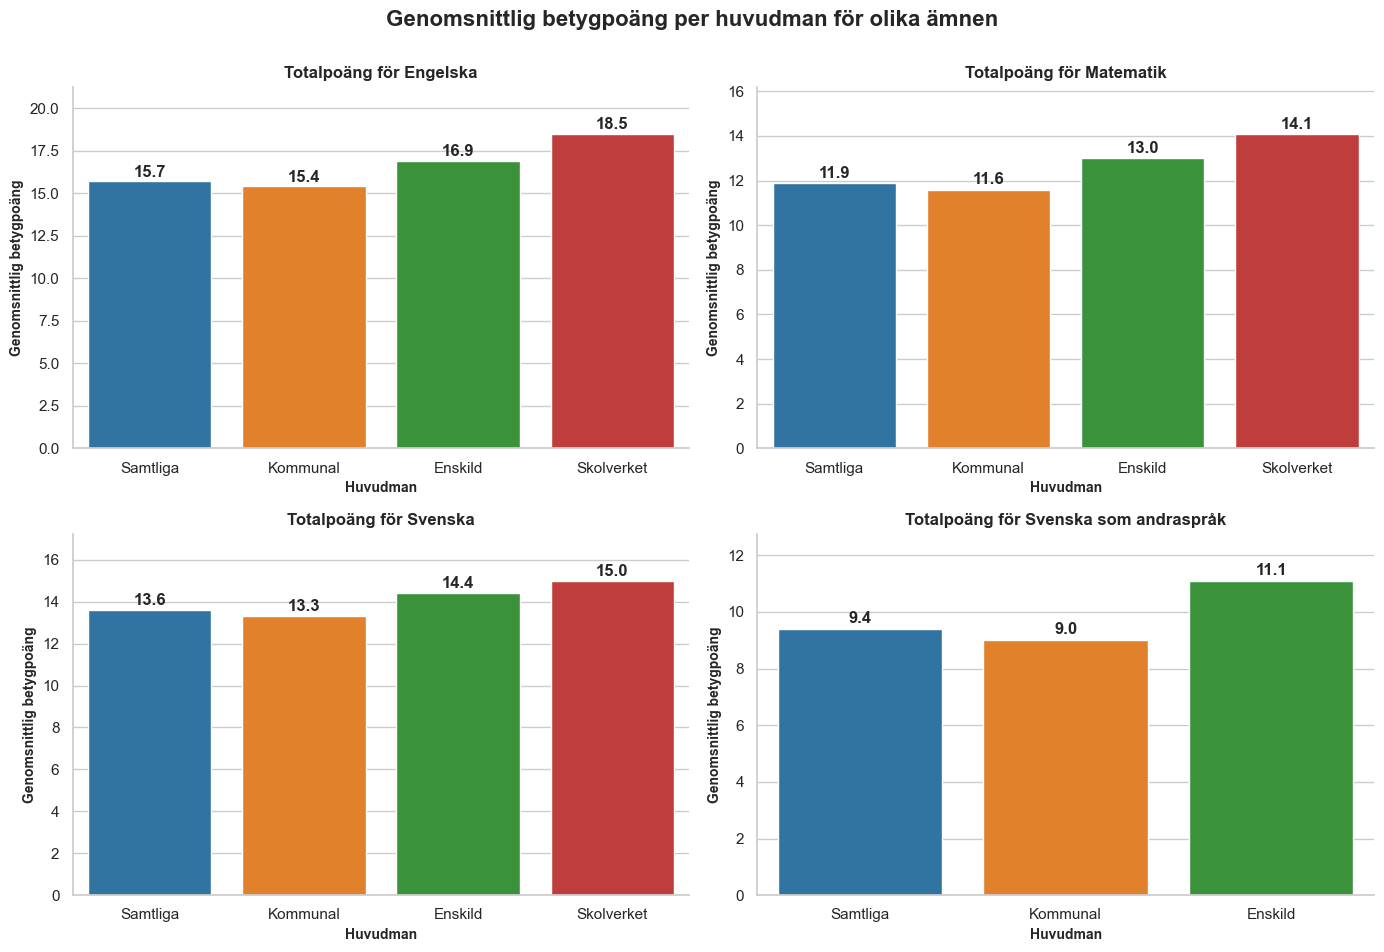


 --- Uppgift 2: Betyg och prov riksnivå ---

2a) Andel elever som saknar godkänt betyg
Figur för andel godkända betyg skapad och sparad som HTML-fil

2b) Medelmeritvärde för 16 ämnen
Figur för meritvärde skapad och sparad som HTML-fil

2c) Föräldrars utbildningsbakgrund
Ingen data tillgänglig för att skapa visualisering

 Anlys slutförd! Alla visualiseringar har sparats i mappen visualiseringar


In [10]:
""" Main function running the analyses """
def main():
    print("\n --- Uppgift 1: Nationella prov ---")
    np_data = load_np_data()
    
    if np_data:
        print_data_table(np_data)
        plot_subject_scores(np_data)
    
    
    print("\n --- Uppgift 2: Betyg och prov riksnivå ---")
    betyg_data = load_betyg_data()
    
    if betyg_data:
        
        print("\n2a) Andel elever som saknar godkänt betyg")
        plot_saknar_godkant(betyg_data['saknar_godkant'])
        
        print ("\n2b) Medelmeritvärde för 16 ämnen")
        plot_meritvarde(betyg_data['meritvarde'])
        
        print("\n2c) Föräldrars utbildningsbakgrund")
        plot_utbildningsbakgrund(betyg_data['utbildning'])
    
    print("\n Anlys slutförd! Alla visualiseringar har sparats i mappen visualiseringar")

if __name__ == '__main__':
    main()